In [1]:
import pandas as pd
import numpy as np
import re
import json
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.losses import categorical_hinge, categorical_crossentropy, sparse_categorical_crossentropy
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns', 550)

# Verify the results
Let's load in the model that we saved and take a look at the results using a sample chunk of data

In [2]:
def top3(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top5(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def top10(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10)

model1 = load_model('models/final_model3.h5', custom_objects={'top3': top3, 'top5': top5, 'top10':top10})
with open('genredict.json') as j1:
    genredict = json.load(j1)

with open('key_scale_dict.json') as j4:
    key_scale_dict = json.load(j4)
with open('key_key_dict.json') as j5:
    key_key_dict = json.load(j5)
outputshape =len(genredict)

key_scale_ind = {v: int(k) for k, v in key_scale_dict.items()}
key_key_ind = {v: int(k) for k, v in key_key_dict.items()}

In [3]:
df = pd.read_parquet('google_cloud_data/final_{}.parquet'.format(20)).drop(columns=['genre', 'thpcp', 'beats_position'])
#df = df.sample(n=1000).reset_index(drop=True)

# Process Data
Let's process the data so we can fit it. The processing pipeline is the same as the last file.

In [4]:
def dstacker(arr1, arr2):
    dstack = []
    for i in range(len(arr1)):
        dstack.append(np.dstack((arr1[i], arr2[i])))
    return np.array(dstack)

df['chords_key'] = df['chords_key'].apply(lambda x: key_key_ind[x])

df['chords_scale'] = df['chords_scale'].apply(lambda x: key_scale_ind[x])

df['key_key'] = df['key_key'].apply(lambda x: key_key_ind[x])

df['key_scale'] = df['key_scale'].apply(lambda x: key_scale_ind[x])

In [5]:
def feature_spliter(df):
    df = df.sample(frac=1).reset_index(drop=True)
    X_flat = df.select_dtypes(exclude=['object']).drop(columns=['count'])
    gfccc = np.array(list(df['gfcc.cov'].apply(lambda x: [i.tolist() for i in x])))/10000
    gfcci = np.array(list(df['gfcc.icov'].apply(lambda x: [i.tolist() for i in x])))
    mfccc = np.array(list(df['mfcc.cov'].apply(lambda x: [i.tolist() for i in x])))/10000
    mfcci = np.array(list(df['mfcc.icov'].apply(lambda x: [i.tolist() for i in x])))
    
    gfcc = dstacker(gfccc, gfcci)
    mfcc = dstacker(mfccc, mfcci)
    
    hpcp = np.array(list(df['hpcp'].apply(lambda x: [i.tolist() for i in x])))
    hpcp = np.expand_dims(hpcp, axis=3)
    
    chord_hist = np.array(list(df['chords_histogram']))/100
    
    barkbands = np.array(list(df['barkbands'].apply(lambda x: [i.tolist() for i in x])))
    barkbands = np.expand_dims(barkbands, axis=3)
    erbbands = np.array(list(df['erbbands'].apply(lambda x: [i.tolist() for i in x])))
    erbbands = np.expand_dims(erbbands, axis=3)
    melbands = np.array(list(df['melbands'].apply(lambda x: [i.tolist() for i in x])))
    melbands = np.expand_dims(melbands, axis=3)
    sccoef = np.array(list(df['spectral_contrast_coeffs'].apply(lambda x: [i.tolist() for i in x])))
    sccoef = np.expand_dims(sccoef, axis=3)
    scvalley = np.array(list(df['spectral_contrast_valleys'].apply(lambda x: [i.tolist() for i in x])))
    scvalley = np.expand_dims(scvalley, axis=3)
    blratio = np.array(list(df['beats_loudness_band_ratio'].apply(lambda x: [i.tolist() for i in x])))
    blratio = np.expand_dims(blratio, axis=3)

    gfmean = np.array(list(df['gfcc.mean']))/100
    mfmean = np.array(list(df['mfcc.mean']))/100
    
    scaler = MinMaxScaler(feature_range=(0.75, 1))
    sample_weights = np.array(list(df['count']))#+1
    sample_weights = np.array(list(map(math.log, sample_weights)))
    sample_weights = scaler.fit_transform(sample_weights.reshape(-1,1))
    sample_weights = sample_weights.squeeze()
    
    Yall = np.array(list(df['cat_cross']))
    df = 0
    return [gfcc, mfcc, X_flat, hpcp, chord_hist, barkbands, erbbands, melbands, sccoef, 
            scvalley, blratio, gfmean, mfmean, sample_weights, Yall]

In [6]:
%%time
inputs = feature_spliter(df.drop(columns=['gid', 'genre_id']))

CPU times: user 2.31 s, sys: 347 ms, total: 2.66 s
Wall time: 2.56 s


In [7]:
model_predict = model1.predict(inputs[:-2])

# Confusion Matrix
Because of the sheer number of genres, for visualization we will only look at the major genres for visualization.

In [8]:
#all genres
CLASSES = [v for k,v in genredict.items()]

#major genres
major_genres = ['rock', 'pop', 'blues','electronic' ,'jazz', 'country', 'metal', 'classical', 'soul', 'reggae', 'punk', 'funk']

In [9]:
Y_test = [np.argmax(i) for i in inputs[-1]]
y_pred = [genredict[str(c)] for c in np.argmax(model_predict, axis=-1)]
y_true = [genredict[str(c)] for c in Y_test]

prediction_df = pd.DataFrame(list(zip(y_pred, y_true)), columns = ['pred', 'true'])
prediction_df['top3'] = top_k_categorical_accuracy(inputs[-1], model_predict, k=3).numpy()
prediction_df['top5'] = top_k_categorical_accuracy(inputs[-1], model_predict, k=5).numpy()
prediction_df['top10'] = top_k_categorical_accuracy(inputs[-1], model_predict, k=10).numpy()
prediction_df.head()

,pred,true,top3,top5,top10
0,r&b,rock,0.0,0.0,0.0
1,rock,rock,1.0,1.0,1.0
2,pop,britpop,0.0,0.0,0.0
3,electronic,dark wave,0.0,0.0,1.0
4,pop,alternative dance,0.0,0.0,0.0


Let's get a dataframe for just the major genres

In [10]:
major_df = prediction_df[prediction_df['pred'].isin(major_genres)]
major_df = major_df[major_df['true'].isin(major_genres)]

## Confusion Matrix Plot

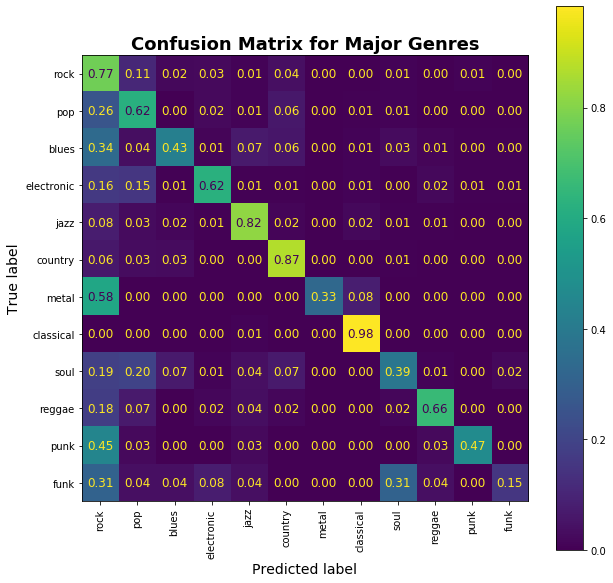

In [11]:
conm_major = confusion_matrix(major_df['true'], major_df['pred'], labels=major_genres, normalize='true')

fig, ax = plt.subplots(figsize=(10,10))

cmd_major = ConfusionMatrixDisplay(conm_major, display_labels=major_genres)

ax.grid(False)
cmd_major.plot(ax=ax, values_format='.2f', xticks_rotation='vertical')
for i in cmd_major.text_: #set font size
    for j in i:
        j.set_size(12)
cmd_major.ax_.yaxis.label.set_size(14)
cmd_major.ax_.xaxis.label.set_size(14)
plt.title('Confusion Matrix for Major Genres', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()

The model is surprisingly good at classifying classical music. Overall, the scores may be inflated due to the fact that I'm also filtering out the predictions as well.

### Symmetric Confusion Matrix
Let's get a better idea of the pairs where the model gets it wrong

In [12]:
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([0/256, 0/256, 0/256, 1])
newcolors[:1, :] = black
newcmp = ListedColormap(newcolors)

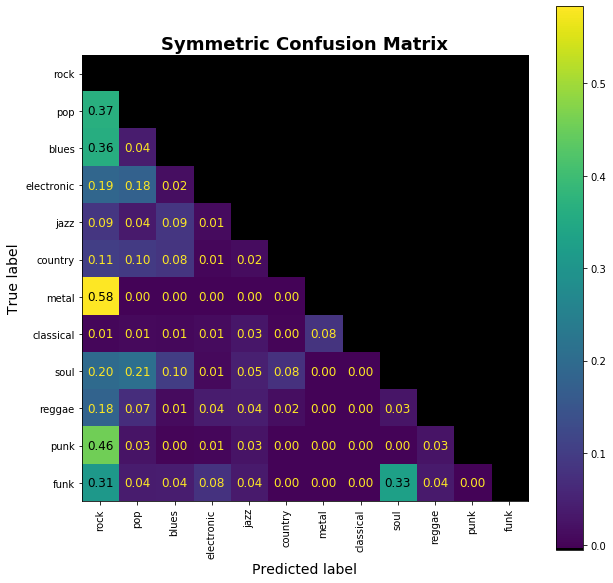

In [13]:
tcm = np.transpose(conm_major)
symscores = tcm+conm_major

fig, ax = plt.subplots(figsize=(10,10))
iu1 = np.triu_indices(len(major_genres))
symscores[iu1] = -0.005

symscoresd = ConfusionMatrixDisplay(symscores, display_labels=major_genres)
ax.grid(False)
symscoresd.plot(ax=ax, values_format='.2f', xticks_rotation='vertical', cmap= newcmp)

for i in symscoresd.text_: #set font size
    for j in i:
        j.set_size(12)

for k in symscoresd.text_[iu1]:
    k.remove()
symscoresd.ax_.yaxis.label.set_size(14)
symscoresd.ax_.xaxis.label.set_size(14)
plt.title('Symmetric Confusion Matrix', fontdict={'fontsize': 18, 'fontweight': 'bold'})
plt.show()

In [14]:
class_mat = major_genres.copy()
class_mat = np.array(class_mat*len(major_genres)).reshape(len(major_genres),len(major_genres))
class_mat_t = np.transpose(class_mat)
class_pair = np.dstack((class_mat_t, class_mat))

combres = np.dstack((class_pair, symscores))

print()
resdict = {}
for i in combres:
    for j in i:
        keypair = j[0] + ", " +j[1]
        resdict.update({keypair: 0})
for i in combres:
    for j in i:
        keypair = j[0] + ", " +j[1]
        if float(j[2]) <0:
            continue
        elif float(j[2]) > resdict[keypair]:
            resdict[keypair] = float(j[2])

deletekey = [k for k,v in resdict.items() if v<=0]
for k in deletekey:
    del resdict[k]
resdict = {k: v for k, v in sorted(resdict.items(), key=lambda item: item[1], reverse=True)}

major_df['strict_correct'] = np.where(major_df['pred'] == major_df['true'], True, False)
print("% correctness under strict measure: ", sum(major_df.loc[:,'strict_correct'])*100/len(major_df))
print("% Top 3 correctness: ", sum(major_df.loc[:,'top3'])*100/len(major_df))
print("% Top 5 correctness: ", sum(major_df.loc[:,'top5'])*100/len(major_df))
print("% Top 10 correctness: ", sum(major_df.loc[:,'top10']*100)/len(major_df))

symtable = pd.DataFrame.from_dict(resdict, orient='index', columns=['sym_score'])
symtable.head(10)


% correctness under strict measure:  76.92307692307692
% Top 3 correctness:  88.8504753673293
% Top 5 correctness:  92.76865456640738
% Top 10 correctness:  96.74445404782483


,sym_score
"metal, rock",0.583333
"punk, rock",0.455795
"pop, rock",0.366842
"blues, rock",0.361315
"funk, soul",0.328526
"funk, rock",0.309097
"soul, pop",0.208786
"soul, rock",0.197331
"electronic, rock",0.190175
"reggae, rock",0.181380


We can clearly see that the model "confuses" metal with rock, punk with rock, and pop with rock most often. Overall, these are very similar genres so the wrongness is acceptable.

# For Other Genres
Of course the major genres are the most common so it's very possible that the model just guesses the major genres to get a higher score. So let's completely eliminate the major genres from the test set by filtering out major genres in the "true" column. But let's be generous here, there are many subgenres which are very similar so let's make it so that if a single word of prediction matches a single word in the true value I will consider that to be correct. The limitation is that the pair with the same prefix such as "post" and "alternative" will be flagged as correct which may inflate the score, but there are also subgenres where they don't share any words especially for electronic genres such as "house" and "trance" with "electronic". Fixing this would require manual intervention and categorization of genres.

In [15]:
# function that returns True if a single word matches
def regex_true(y_pred, y_true):
    pred_set = set(re.split(r'\s|-', y_pred))
    true_set = set(re.split(r'\s|-', y_true))
    for i in pred_set:
        for j in true_set:
            if len(re.findall(i, j))>0:
                return True
    return False

With a strict definition of correctness of a genre we see that the model performs much more poorly, however we still see that the model is still generalizing given that a lower standard produces a higher result

In [16]:
minor_df = prediction_df.query("true not in @major_genres")
#minor_df = minor_df.query("pred not in @macrogenre")
minor_df['strict_correct'] = np.where(minor_df['pred'] == minor_df['true'], True, False)
minor_df['loose_correct'] = minor_df.loc[:,['pred', 'true']].apply(lambda x: regex_true(*x), axis=1)
print("% correctness under strict measure: ", sum(minor_df.loc[:,'strict_correct'])*100/len(minor_df))
print("% correctness under the regex standard: ", sum(minor_df.loc[:,'loose_correct'])*100/len(minor_df))
print("% Top 3 correctness: ", sum(minor_df.loc[:,'top3'])*100/len(minor_df))
print("% Top 5 correctness: ", sum(minor_df.loc[:,'top5'])*100/len(minor_df))
print("% Top 10 correctness: ", sum(minor_df.loc[:,'top10'])*100/len(minor_df))
#minor_df.head()

% correctness under strict measure:  23.57894736842105
% correctness under the regex standard:  51.93684210526316
% Top 3 correctness:  47.22105263157895
% Top 5 correctness:  59.915789473684214
% Top 10 correctness:  76.10526315789474


/home/cheinu/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/cheinu/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


We can take the mean of all the scores. This will favor certain genres that are only present only a handful of times but we have an idea of where the model gets it correct.

In [17]:
strict_score = pd.DataFrame(minor_df.groupby('true')['strict_correct'].mean().sort_values(ascending=False))
loose_score = pd.DataFrame(minor_df.groupby('true')['loose_correct'].mean().sort_values(ascending=False))
top3_score = pd.DataFrame(minor_df.groupby('true')['top3'].mean().sort_values(ascending=False))
top5_score = pd.DataFrame(minor_df.groupby('true')['top5'].mean().sort_values(ascending=False))
top10_score = pd.DataFrame(minor_df.groupby('true')['top10'].mean().sort_values(ascending=False))

normalized_minor_scores = strict_score.join(loose_score).join(top3_score).join(top5_score).join(top10_score)

In [18]:
normalized_minor_scores.head(20)

,strict_correct,loose_correct,top3,top5,top10
true,,,,,
ethereal,1.000000,1.000000,1.000000,1.000000,1.000000
flamenco,1.000000,1.000000,1.000000,1.000000,1.000000
happy hardcore,1.000000,1.000000,1.000000,1.000000,1.000000
production music,0.954545,0.954545,0.972727,0.972727,1.000000
vocal jazz,0.800000,0.800000,0.800000,0.800000,1.000000
drum and bass,0.771429,0.771429,0.857143,0.857143,0.914286
classic country,0.769231,0.846154,0.923077,0.923077,1.000000
comedy,0.753846,0.753846,0.815385,0.846154,0.876923
spoken word,0.750000,0.750000,1.000000,1.000000,1.000000


### Regex standard for the Entire Test Data
I forgot to do this but I'll do this here so I don't have to reformat everything.

In [19]:
prediction_df['loose_correct'] = prediction_df.loc[:,['pred', 'true']].apply(lambda x: regex_true(*x), axis=1)
print("% correctness under the regex standard: ", sum(prediction_df.loc[:,'loose_correct'])*100/len(prediction_df))

% correctness under the regex standard:  60.56745801968732
